# Импорт библиотек и данных

Launch a server via:
```bash
mlflow server --host 127.0.0.1 --port 8080
```

In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.models import infer_signature

from sklearn.linear_model import LinearRegression

root_folder = '../'
sys.path.append(root_folder)

from src.visualization import visualize

baseline_data = Path(root_folder, 'data', 'processed', '1.0_baseline.csv')

In [2]:
mlflow.artifacts.list_artifacts

<function mlflow.artifacts.list_artifacts(artifact_uri: Optional[str] = None, run_id: Optional[str] = None, artifact_path: Optional[str] = None, tracking_uri: Optional[str] = None)>

In [3]:
params = {
    "solver": "lbfgs",
    "max_iter": 1000,
    "multi_class": "auto",
    "random_state": 8888,
}

params2 = {
    "solver2": "lbfgs",
    "max_iter2": 1000,
    "multi_class2": "auto",
    "random_state2": 8888,
}

params = params | params2

In [4]:
df = pd.read_csv(
    baseline_data,
    index_col=0
)
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 374306 entries, 0 to 374305
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   baths         267467 non-null  float64
 1   fireplace     374306 non-null  bool   
 2   sqft          333384 non-null  float64
 3   beds          277504 non-null  float64
 4   stories       221109 non-null  float64
 5   target        374306 non-null  int64  
 6   private_pool  374306 non-null  bool   
 7   mls           374306 non-null  bool   
 8   year_built    311041 non-null  float64
dtypes: bool(3), float64(5), int64(1)
memory usage: 21.1 MB


,baths,sqft,beds,stories,target,year_built
count,267467.000000,3.333840e+05,277504.000000,221109.000000,3.743060e+05,311041.00000
mean,3.384831,6.651283e+03,3.901398,1.992208,6.454072e+05,1979.34852
std,22.286381,1.589502e+06,21.223677,4.265755,1.842196e+06,33.59876
min,0.000000,0.000000e+00,0.000000,0.000000,1.000000e+00,1700.00000
25%,2.000000,1.242000e+03,3.000000,1.000000,1.877965e+05,1957.00000
50%,2.500000,1.800000e+03,3.000000,2.000000,3.200000e+05,1985.00000
75%,3.000000,2.589000e+03,4.000000,2.000000,5.845000e+05,2007.00000
max,750.000000,7.959794e+08,750.000000,1120.000000,1.950000e+08,2022.00000


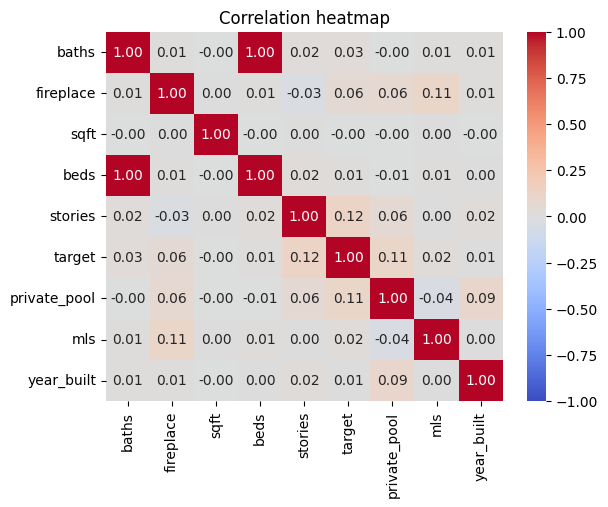

In [5]:
visualize.plot_heatmap(
    df.corr(),
    title='Correlation heatmap',
);

Видим сильную корреляцию колиества спален и ванный комнат, что нужно иметь ввиду.

In [4]:
df = df.drop('baths', axis=1)

In [5]:
# df = df.dropna()

In [6]:
df_crop = df[df['target'].between(1e5, 1e6)]
df = df_crop

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

random_state = 42

X = df.drop('target', axis=1)
y = df['target']
# y = np.log10(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state
)

imputer_median = SimpleImputer(
    missing_values=np.nan,
    strategy='median'
)
scaler_minmax = MinMaxScaler()
lin_reg = DecisionTreeRegressor(max_depth=10)

pipe_baseline = Pipeline(
    [
        ('imputer', imputer_median),
        ('scaler', scaler_minmax),
        ('regressor', lin_reg)
    ]
)

pipe_baseline.fit(X_train, y_train)
y_pred = pipe_baseline.predict(X_test)
# imp_median.fit_transform(df)

In [11]:
pd.Series(y_test).describe()

count      85525.000000
mean      381027.418860
std       211698.381498
min       100000.000000
25%       220000.000000
50%       324900.000000
75%       495000.000000
max      1000000.000000
Name: target, dtype: float64

In [12]:
pd.Series(y_pred).describe()

count    8.552500e+04
mean     3.803537e+05
std      5.608908e+04
min      2.804279e+05
25%      3.554450e+05
50%      3.629307e+05
75%      4.051924e+05
max      1.283282e+07
dtype: float64

In [8]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# TODO: Get test and train metrics!
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAPE = {mape*100:.2f}%')
print(f'R^2 = {r2}')

MAPE = 50.60%
R^2 = 0.1566351088591066


We obtain awfull result

In [5]:
imp_median.feature_names_in_

array(['baths', 'fireplace', 'sqft', 'beds', 'stories', 'target',
       'private_pool', 'mls', 'year_built'], dtype=object)